## Recognition of hand drawings with CNNs and using the dataset of Quick-Draw API & generating synonyms of the predicted drawing

* Minor Applied Artificial Intelligence HvA
* Aghead Bilal

### Importing packages

In [2]:
%load_ext tensorboard

In [3]:
import datetime, os
import tensorflow as tf

from pathlib import Path
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData

from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

from tensorflow.keras.callbacks import TensorBoard

### Dataset generation

In [4]:
image_size = (28, 28)

To train the neural network, we generate our own dataset by making slight modifications to the Google dataset. <br>
We will employee a Python package called quickdraw to download and access the dataset from the Google Cloud Platform.

In [ ]:
# Load 1200 training images for each class from the cloud storage
# Resize each image to 28x28 pixels
# Save the resized images in PNG format
def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    # If recognized=True is set, it guarantees that only images recognized by Google's AI will be loaded.
    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

for label in QuickDrawData().drawing_names:
    generate_class_images(label, max_drawings=1200, recognized=True)

### Dataset loading/splitting

The images will be loaded using the Keras image_dataset_from_directory function and will then be divided into training and validation sets.

In [5]:
# Batch size is a hyperparameter that determines the number of training examples used in one iteration
batch_size = 32 

# The dataset will be split into an 80% training set and a 20% validation set.
train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 414000 files belonging to 345 classes.
Using 331200 files for training.
Found 414000 files belonging to 345 classes.
Using 82800 files for validation.


### Visualization

After we split the dataset, let's visualize some random training images.

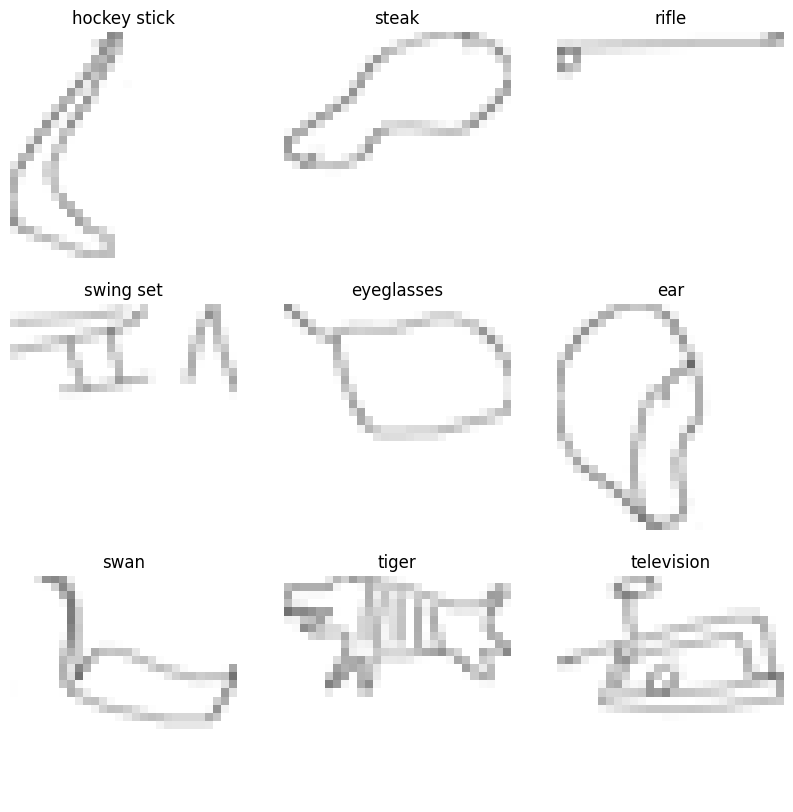

In [6]:
# plot 9 random hand drawings with its title from the training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

### Architecture (Building CNN)

We will start by using the seven Keras layers to create our convolutional neural network.

In [11]:
input_shape = (28, 28, 1)
n_classes = 345

model = Sequential([
    Rescaling(1. / 255, input_shape=input_shape),
    BatchNormalization(),

    Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(700, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(500, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(400, activation='relu'),
    Dropout(0.2),

    Dense(n_classes, activation='softmax')
])

In [12]:
model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         60        
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         440       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 10)        730       
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 10)       40        
 hNormalization)                                        

### Training

We will train the convolutional neural network for 10 epochs using the Quick, Draw! dataset (for improvement)

In [14]:
epochs = 10

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback]
)

model.save('./models/model_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Epoch 1/10
10350/10350 [==============================] - 820s 79ms/step - loss: 2.8577 - accuracy: 0.3373 - val_loss: 2.2617 - val_accuracy: 0.4392
Epoch 2/10
10350/10350 [==============================] - 560s 54ms/step - loss: 2.1301 - accuracy: 0.4653 - val_loss: 1.7450 - val_accuracy: 0.5481
Epoch 3/10
10350/10350 [==============================] - 482s 47ms/step - loss: 1.8959 - accuracy: 0.5120 - val_loss: 1.6240 - val_accuracy: 0.5738
Epoch 4/10
10350/10350 [==============================] - 531s 51ms/step - loss: 1.7581 - accuracy: 0.5411 - val_loss: 1.6104 - val_accuracy: 0.5782
Epoch 5/10
10350/10350 [==============================] - 578s 56ms/step - loss: 1.6630 - accuracy: 0.5611 - val_loss: 1.6283 - val_accuracy: 0.5754
Epoch 6/10
10350/10350 [==============================] - 523s 51ms/step - loss: 1.5943 - accuracy: 0.5756 - val_loss: 1.4914 - val_accuracy: 0.6068
Epoch 7/10
10350/10350 [==============================] - 528s 51ms/step - loss: 1.5387 - accuracy: 0.5878

INFO:tensorflow:Assets written to: ./models/model_20230506-152501\assets


INFO:tensorflow:Assets written to: ./models/model_20230506-152501\assets


In [15]:
# The accuracy of the model on the validation set
val_loss, val_acc = model.evaluate(val_ds)
print("Validation accuracy: ", val_acc)

# The accuracy of the model on the training set
train_loss, train_acc = model.evaluate(train_ds)
print("Training accuracy: ", train_acc)


2588/2588 [==============================] - 34s 13ms/step - loss: 1.4725 - accuracy: 0.6181
Validation accuracy:  0.6180555820465088
10350/10350 [==============================] - 144s 14ms/step - loss: 0.9432 - accuracy: 0.7307
Training accuracy:  0.7307367324829102


<b>

The validation accuracy is lower than the training accuracy, which is expected because the model has learned to fit the training data well, but it may not generalize well to new data.

An accuracy of 62% is actually not bad considering that there are 345 categories, some of which may be quite similar to each other.

Overall, the model's performance can be considered moderate, but it may be improved with further optimization.

1/1 [==============================] - 0s 23ms/step
Prediction:  star
1/1 [==============================] - 0s 22ms/step
Prediction:  sleeping bag
1/1 [==============================] - 0s 24ms/step
Prediction:  nose
1/1 [==============================] - 0s 25ms/step
Prediction:  computer
1/1 [==============================] - 0s 26ms/step
Prediction:  washing machine
1/1 [==============================] - 0s 23ms/step
Prediction:  whale
1/1 [==============================] - 0s 22ms/step
Prediction:  alarm clock
1/1 [==============================] - 0s 25ms/step
Prediction:  pool
1/1 [==============================] - 0s 28ms/step
Prediction:  waterslide


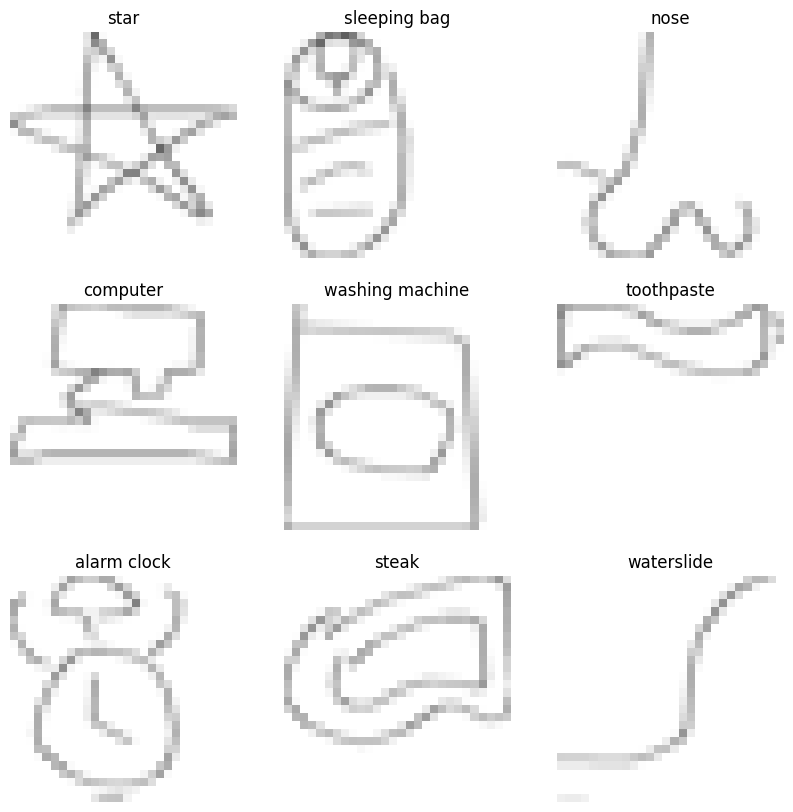

In [18]:
# plot 9 drawings from the validation set and its prediction from the model
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

        prediction = model.predict(images[i:i+1])
        print("Prediction: ", train_ds.class_names[tf.argmax(prediction[0])])

In [ ]:
%tensorboard --logdir logs

### Improving CNN

In [55]:
# improve the model by adding more layers
model = Sequential([
    Rescaling(1. / 255, input_shape=input_shape),
    BatchNormalization(),

    Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(12, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(14, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),

    Dense(700, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(500, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(400, activation='relu'),
    Dropout(0.2),

    Dense(n_classes, activation='softmax')
])

In [56]:
model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 batch_normalization_14 (Bat  (None, 28, 28, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 6)         60        
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 8)         440       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 10)        730       
                                                                 
 batch_normalization_15 (Bat  (None, 28, 28, 10)       40        
 chNormalization)                                     

We will train the improved convolutional neural network for 10 epochs using the Quick, Draw! dataset (for improvement)

In [17]:
epochs = 10

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback]
)

model.save('./models/model_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Epoch 1/10
10350/10350 [==============================] - 768s 74ms/step - loss: 3.0668 - accuracy: 0.3023 - val_loss: 2.0317 - val_accuracy: 0.4819
Epoch 2/10
10350/10350 [==============================] - 500s 48ms/step - loss: 2.2403 - accuracy: 0.4402 - val_loss: 1.8087 - val_accuracy: 0.5321
Epoch 3/10
10350/10350 [==============================] - 502s 49ms/step - loss: 2.0124 - accuracy: 0.4865 - val_loss: 1.6236 - val_accuracy: 0.5722
Epoch 4/10
10350/10350 [==============================] - 500s 48ms/step - loss: 1.8910 - accuracy: 0.5125 - val_loss: 1.5663 - val_accuracy: 0.5857
Epoch 5/10
10350/10350 [==============================] - 494s 48ms/step - loss: 1.8136 - accuracy: 0.5282 - val_loss: 1.6729 - val_accuracy: 0.5603
Epoch 6/10
10350/10350 [==============================] - 527s 51ms/step - loss: 1.7582 - accuracy: 0.5400 - val_loss: 1.4771 - val_accuracy: 0.6077
Epoch 7/10
10350/10350 [==============================] - 499s 48ms/step - loss: 1.7177 - accuracy: 0.5502

INFO:tensorflow:Assets written to: ./models/model_20230506-200636\assets


INFO:tensorflow:Assets written to: ./models/model_20230506-200636\assets


In [18]:
# The accuracy of the model on the validation set
val_loss, val_acc = model.evaluate(val_ds)
print("Validation accuracy: ", val_acc)

# The accuracy of the model on the training set
train_loss, train_acc = model.evaluate(train_ds)
print("Training accuracy: ", train_acc)

2588/2588 [==============================] - 33s 13ms/step - loss: 1.4144 - accuracy: 0.6207
Validation accuracy:  0.620724618434906
10350/10350 [==============================] - 136s 13ms/step - loss: 1.2166 - accuracy: 0.6623
Training accuracy:  0.6623249053955078


<b>

After adding more layers we got an accuracy of 62%

In [59]:
# Load model_20230506-200636
model = tf.keras.models.load_model('./models/model_20230506-200636')

1/1 [==============================] - 0s 175ms/step
Prediction:  microwave
1/1 [==============================] - 0s 24ms/step
Prediction:  scissors
1/1 [==============================] - 0s 23ms/step
Prediction:  microphone
1/1 [==============================] - 0s 24ms/step
Prediction:  cookie
1/1 [==============================] - 0s 25ms/step
Prediction:  mountain
1/1 [==============================] - 0s 25ms/step
Prediction:  square
1/1 [==============================] - 0s 24ms/step
Prediction:  mouth
1/1 [==============================] - 0s 25ms/step
Prediction:  beach
1/1 [==============================] - 0s 27ms/step
Prediction:  bear


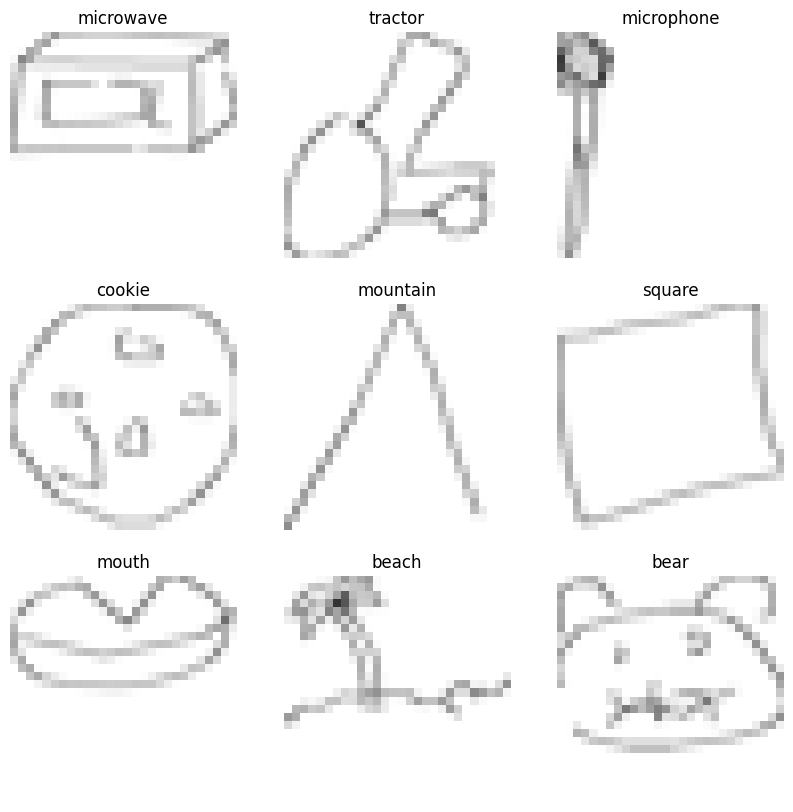

In [60]:
# plot 9 drawings from the validation set and its prediction from the model
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

        prediction = model.predict(images[i:i+1])
        print("Prediction: ", train_ds.class_names[tf.argmax(prediction[0])])

1/1 [==============================] - 0s 23ms/step
Prediction:  sun


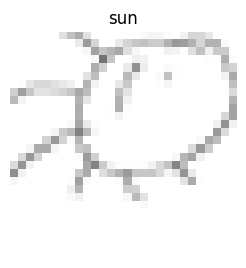

In [63]:
# plot a  drawing from the validation set and its prediction from the model
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    ax = plt.subplot(3, 3, 1)
    data = images[0].numpy().astype("uint8")
    plt.imshow(data, cmap='gray', vmin=0, vmax=255)
    plt.title(train_ds.class_names[labels[0]])
    plt.axis("off")

    prediction = model.predict(images[0:1])
    print("Prediction: ", train_ds.class_names[tf.argmax(prediction[0])])

### word vectorization of the predicted drawing

In [1]:
import nltk
import gensim
import random
import math

nltk.download('word2vec_sample', download_dir='word_vectorization')

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     word_vectorization...
[nltk_data]   Unzipping models\word2vec_sample.zip.


True

In [25]:
word2vec_sample = str(r"word_vectorization\models\word2vec_sample\pruned.word2vec.txt")

modelSynonym = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary = False)

# wordToGetSynonymFor = train_ds.class_names[tf.argmax(prediction[0])]
wordToGetSynonymFor = "sun"

top = modelSynonym.most_similar(positive = [wordToGetSynonymFor], topn = 50)

In [26]:
listOfTops = [];

# Remove the 'Distanse' between the words, so that we are simply left with strings.
for t in top:
    listOfTops.append(t[0])

# The words to get removed.
withS = wordToGetSynonymFor + 's'
withCapital = wordToGetSynonymFor.capitalize()
withBoth = withS.capitalize()

# Remove words that add an s, or start with a capital letter of the originial word.
# This will only work if its on a seperate loop?!
for t in listOfTops:
    if t == withCapital:
        listOfTops.remove(t)

for t in listOfTops:
    if t == withS:
        listOfTops.remove(t)
    
    if t == withBoth:
        listOfTops.remove(t)

# The list of words.
print(listOfTops)

['sunlight', 'sunshine', 'rays', 'sunny', 'shade', 'starlight', 'moonlight', 'sunburn', 'balmy', 'sunrise', 'daylight', 'mist', 'darkness', 'dusk', 'heat', 'cloudless', 'glow', 'breezes', 'overcast', 'temperatures', 'sweltering', 'sky', 'brightness', 'sunset', 'breeze', 'humid', 'equator', 'misty', 'ultraviolet', 'solstice', 'windless', 'glare', 'frost', 'raindrops', 'rain', 'sunburnt', 'twilight', 'rainless', 'warmish', 'moon', 'dew', 'humidity', 'cloudy', 'clouds', 'temperature', 'moonlit', 'windy', 'lamplight', 'muggy']


By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
twilight sun sketch.
10/10 [==============================] - 151s 9s/step
None


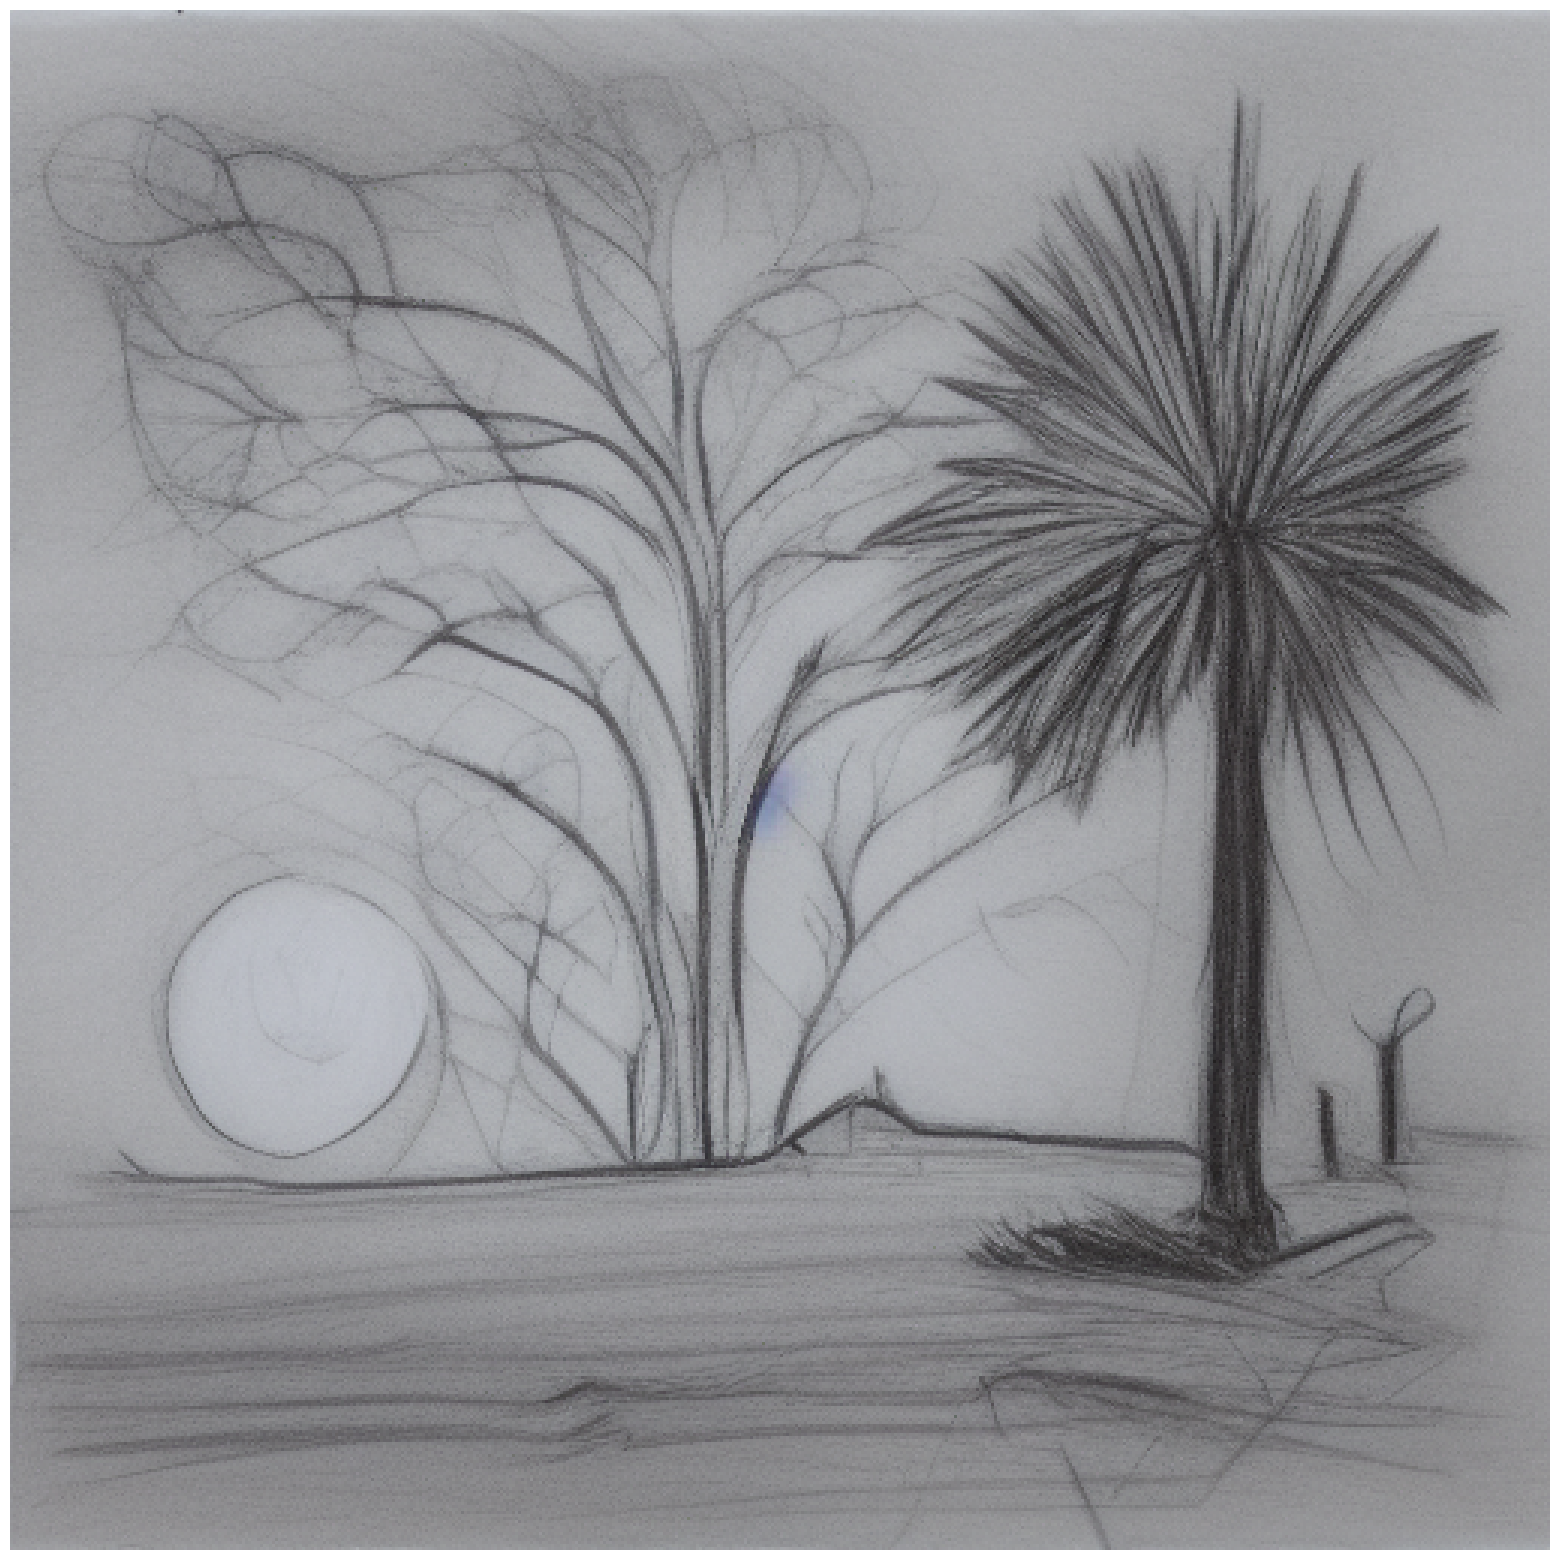

In [28]:
# https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/
# No gpu, should work but doesn't??
# No internet required, just once so that it is loaded.

import time
import keras_cv
import tensorflow as tf
import matplotlib.pyplot as plt
    
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512, jit_compile=True)
prompt = listOfTops[random.randrange(len(listOfTops))] + " " + wordToGetSynonymFor + " sketch."
print(prompt)

images = model.text_to_image(
    prompt=prompt,
    batch_size=1,  # How many images to generate at once
    num_steps=10,  # Number of iterations (controls image quality)
    seed=123,  # Set this to always get the same image from the same prompt
)


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


print(plot_images(images))